In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.grid_search import GridSearchCV

# set random state to use throughout
rs = 25

In [2]:
# import data and format it
data = pd.read_csv('../Data/gss_subset_cleaned.csv')
data = data[data['year']> 2005]
# drop highly correlated columns and unusable columns identified in earlier analysis
data.drop(['paeduc', 'maeduc', 'speduc', 'income', 'satjob', 'goodlife', 
           'health', 'year', 'hompop', 'earnrs'], axis=1, inplace=True)
# drop less important features from first run-through of RF
data.drop(['babies', 'preteen', 'teens', 'divorce', 'dwelling', 'sex'], axis=1, inplace=True)
# drop NA
data.dropna(inplace=True)

In [3]:
# set X and y
X = pd.get_dummies(data.drop('happy', axis=1), drop_first=True)
y = data['happy'] == 1 # y is "true" when individual is unhappy

In [4]:
# look at % in each class
y.value_counts()/y.count()

False    0.861537
True     0.138463
Name: happy, dtype: float64

In [5]:
# do train_test split
X1_train, X1_test, y_train, y_test = train_test_split(X, y,
        stratify = y, test_size=0.2, random_state=rs)

In [6]:
# instantiate Random Forest
rf = RandomForestClassifier(random_state=rs, n_jobs=-1)

In [8]:
# define param grid for gridsearch
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [15,18,21],
    'n_estimators': [15,18],
    'min_samples_split': [30,40,50],
    'min_samples_leaf': [5,10,20],
    'max_features': [5,10,'auto']
}

In [9]:
# instantiate gridsearch for random forest
gsrf = GridSearchCV(rf, param_grid, n_jobs=-1, scoring = 'roc_auc')

## Run and Evaluate Model on Fuller Training Set (including subjective features that would need to be assessed in interview)

In [10]:
# fit GS RF on training data, print best estimator and out-of-sample score
gsrf.fit(X1_train, y_train)
print gsrf.best_estimator_
print gsrf.score(X1_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=18, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)
0.760678234607


/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [11]:
# Calculate prediction probabilities, use threshold of 15% to classify as unhappy
gsrf_proba1 = gsrf.predict_proba(X1_test)
gsrf_pred1 = gsrf_proba1[:,1] > 0.15
print classification_report(y_test, gsrf_pred1)
print confusion_matrix(y_test, gsrf_pred1)

             precision    recall  f1-score   support

      False       0.93      0.66      0.78      1877
       True       0.25      0.71      0.37       302

avg / total       0.84      0.67      0.72      2179

[[1245  632]
 [  88  214]]


In [12]:
# look at relative importance of different features
features = X1_train.columns
importances = gsrf.best_estimator_.feature_importances_
feat_importances = pd.DataFrame(index=features, columns = ['importance'])
feat_importances['importance'] = importances
feat_importances.sort_values(by='importance', ascending = False)

,importance
satfin,0.274629
educ,0.107291
age,0.093875
weekswrk,0.086070
marital_married,0.077803
sibs,0.066227
dwelown_owns,0.052935
adults,0.048419
polviews,0.042918
childs,0.036023


## Run and Evaluate Model on More Realistic Training Set (including only demographic/biographic information)

In [13]:
# drop subjective features
X2_train = X1_train.drop(['satfin', 'weekswrk', 'polviews'], axis=1)
X2_test = X1_test.drop(['satfin', 'weekswrk', 'polviews'], axis=1)

# fit GS RF and print best estimator, out-of-sample score
gsrf.fit(X2_train, y_train)
print gsrf.best_estimator_
print gsrf.score(X2_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)
0.710488944243


In [14]:
# Calculate prediction probabilities, use threshold of 15% to classify as unhappy
gsrf_proba2 = gsrf.predict_proba(X2_test)
gsrf_pred2 = gsrf_proba2[:,1] > 0.15
print classification_report(y_test, gsrf_pred2)
print confusion_matrix(y_test, gsrf_pred2)

             precision    recall  f1-score   support

      False       0.93      0.66      0.77      1877
       True       0.24      0.68      0.36       302

avg / total       0.83      0.66      0.71      2179

[[1241  636]
 [  97  205]]


In [15]:
# look at relative importance of different features
features = X2_train.columns
importances = gsrf.best_estimator_.feature_importances_
feat_importances = pd.DataFrame(index=features, columns = ['importance'])
feat_importances['importance'] = importances
feat_importances.sort_values(by='importance', ascending = False)

,importance
educ,0.203819
age,0.170816
marital_married,0.129139
sibs,0.103949
dwelown_owns,0.078555
adults,0.075287
childs,0.056447
marital_separated,0.048854
dwelown_rents,0.031688
marital_never_married,0.030360


## Look at Model Value-Add

In [16]:
def getPlotValueAdd(probas, y_test):
    # create dataframe with the model's predicted P(unhappy) along with boolean for actual unhappiness
    modelprobs = pd.DataFrame()
    modelprobs['Model_Prob_Unhappy'] = probas[:,1]
    modelprobs['Unhappy_True'] = y_test.as_matrix()

    # sort by P(Unhappy) and add columns for % Unhappy and % Happy people falling above that threshold
    modelprobs.sort_values(by='Model_Prob_Unhappy', axis=0, inplace=True, ascending=False)
    modelprobs['portion_unhappy_captured'] = np.cumsum(modelprobs['Unhappy_True'])/np.sum(modelprobs['Unhappy_True'])
    modelprobs['portion_happy_mislabeled'] = np.cumsum(1-modelprobs['Unhappy_True'])/np.sum(1-modelprobs['Unhappy_True'])
    modelprobs['ratio_correct_prediction'] = np.cumsum(modelprobs['Unhappy_True'])/(np.cumsum(modelprobs['Unhappy_True']) + np.cumsum(1-modelprobs['Unhappy_True']))

    # Plot the difference
    x = modelprobs['Model_Prob_Unhappy']
    y1 = modelprobs['portion_unhappy_captured']
    y2 = modelprobs['portion_happy_mislabeled']
    y3 = modelprobs['ratio_correct_prediction']
    plt.plot(x, y1, 'b--', x, y2, 'r--', x, y3, 'g--')
    
    # return DF
    return modelprobs

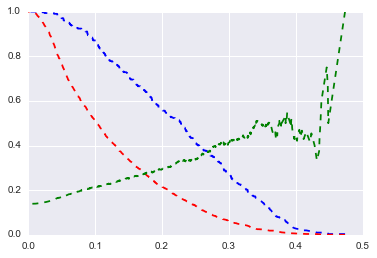

In [17]:
# look at value add for model with more features
modelprobs1 = getPlotValueAdd(gsrf_proba1, y_test)

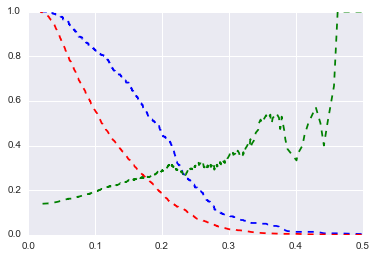

In [18]:
# look at value add for 'more realistic' model
modelprobs2 = getPlotValueAdd(gsrf_proba2, y_test)

## Save Data for Model FPR vs Recall

In [19]:
melted = pd.melt(modelprobs2, id_vars= ['Model_Prob_Unhappy', 'Unhappy_True'])

In [20]:
melted.to_csv('../Data/rf_proba_test.csv', index=False, encoding='utf-8')